In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
train_data = pd.read_csv('../data/train.csv.zip')

In [7]:
train_data.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
25854,25854,48165,48166,"What is the definition of ""demand creation""?",Do you have any advice for a young entrepreneur?,0
45167,45167,80962,80963,What are the home remedies for throat pain?,What is the home remedy for heart pain?,0
44511,44511,79869,79870,What are possible causes of a right side stitc...,What could cause the right side of my head to ...,0
102446,102446,169498,169499,What can I do to get my Mother over from the d...,"As someone from India, can I call my mom and s...",0
78720,78720,134178,134179,Is it grammatically correct to put a comma aft...,What is relation between kp and kc?,0
159736,159736,21317,135230,How do I recover/reset my AOL email password?,What can I do if I forgot my AOL username and ...,1
200256,200256,301975,301976,Do people generally feel that Robb Stark made ...,"In the HBO series Game of Thrones, was the act...",0
228291,228291,337325,136992,What is segments?,What is segmentation?,0
351533,351533,3738,16137,What does superbcrew.com do?,What is flixcart.com?,0
330742,330742,147570,114122,What is the best self help book you have read?...,Which is the best self help book you've ever r...,1


In [8]:
train_data.shape

(404290, 6)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [5]:
from sklearn.model_selection import cross_val_score

In [6]:
import seaborn as sns

In [7]:
# plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

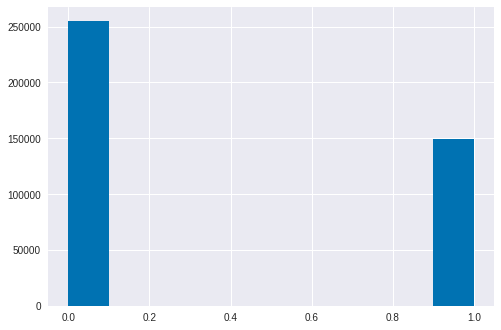

In [40]:
train_data.is_duplicate.hist()

Looks like there are twice as many non-duplicates in the training set so may need to down-sample.

In [9]:
train_data['paired_doc'] = train_data.question1 + ' ' + train_data.question2

In [10]:
train_data.paired_doc.sample(5)

154812    What way to write a CV would impress an interv...
317414    What is it like flying from Bangkok to Manila ...
356303    Which is a better place to live: Goa or Mumbai...
337065    What are some Pokemon that look like dogs? Wha...
383712    Girl Rapes: My gf told me that her step brothe...
Name: paired_doc, dtype: object

In [11]:
train_data.paired_doc.isnull().sum()

2

In [12]:
train_data[train_data.paired_doc.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate,paired_doc
105780,105780,174363,174364,How can I develop android app?,NaN,0,NaN
201841,201841,303951,174364,How can I create an Android app?,NaN,0,NaN


In [13]:
train_data_clean = train_data[train_data.paired_doc.notnull()]
print('before:', train_data.shape, '\n',
      'after:', train_data_clean.shape)

before: (404290, 7) 
 after: (404288, 7)


In [68]:
X_train = train_data_clean.paired_doc.values
y_train = train_data_clean.is_duplicate.values

In [93]:
nb_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [88]:
nb_scores = cross_val_score(nb_clf, X_train, y_train, cv=10, 
#                             scoring='f1', 
                            scoring='neg_log_loss',
                            n_jobs=-1)

In [89]:
nb_scores

array([-0.52115399, -0.51668381, -0.51595932, -0.51321476, -0.51964142,
       -0.52102078, -0.52016738, -0.51535808, -0.52089262, -0.51798406])

In [90]:
np.mean(nb_scores)

-0.51820762116578578

In [115]:
score_df = pd.DataFrame({'naive_bayes': nb_scores})
score_df.describe()

,naive_bayes
count,10.000000
mean,-0.518208
std,0.002792
min,-0.521154
25%,-0.520711
50%,-0.518813
75%,-0.516140
max,-0.513215


In [94]:
log_reg_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='log', penalty='l2', 
                          alpha=1e-3, n_iter=5, random_state=42)),
])

In [95]:
lin_svm_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', 
                          alpha=1e-3, n_iter=5, random_state=42)),
])

In [97]:
log_reg_scores = cross_val_score(log_reg_clf, X_train, y_train, cv=10, 
#                             scoring='f1', 
                            scoring='neg_log_loss',
                            n_jobs=-1)

In [116]:
score_df['log_reg'] = pd.Series(log_reg_scores)

In [119]:
score_df.describe()

,naive_bayes,log_reg
count,10.000000,10.000000
mean,-0.518208,-0.606932
std,0.002792,0.000593
min,-0.521154,-0.607860
25%,-0.520711,-0.607194
50%,-0.518813,-0.606919
75%,-0.516140,-0.606506
max,-0.513215,-0.606140


In [120]:
lin_svm_scores = cross_val_score(lin_svm_clf, X_train, y_train, cv=10, 
                            scoring='f1', 
#                             scoring='neg_log_loss',
                            n_jobs=-1)

In [122]:
score_df['lin_svm'] = pd.Series(lin_svm_scores)
score_df.describe()

,naive_bayes,log_reg,lin_svm
count,10.000000,10.000000,10.000000
mean,-0.518208,-0.606932,0.200836
std,0.002792,0.000593,0.005101
min,-0.521154,-0.607860,0.194307
25%,-0.520711,-0.607194,0.197265
50%,-0.518813,-0.606919,0.199175
75%,-0.516140,-0.606506,0.203993
max,-0.513215,-0.606140,0.209435


In [15]:
from leven import levenshtein

In [130]:
levenshtein(train_data_clean.question1.loc[0], train_data_clean.question2.loc[0])

9

In [16]:
train_data_clean['levenshtein_dist'] = train_data_clean.loc[:, ['question1', 'question2']].apply(
    lambda x: levenshtein(*x), axis=1
)

/home/rucy/Projects/quora_pairs/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [132]:
train_data_clean.levenshtein_dist.describe()

count    404288.000000
mean         38.986228
std          32.384500
min           1.000000
25%          16.000000
50%          31.000000
75%          53.000000
max        1087.000000
Name: levenshtein_dist, dtype: float64

In [14]:
train_data_clean['q1_length'] = train_data_clean.question1.apply(len)
train_data_clean['q2_length'] = train_data_clean.question2.apply(len)

/home/rucy/Projects/quora_pairs/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rucy/Projects/quora_pairs/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [136]:
train_data_clean.describe()

,id,qid1,qid2,is_duplicate,levenshtein_dist,q1_length,q2_length
count,404288.000000,404288.000000,404288.000000,404288.000000,404288.000000,404288.000000,404288.000000
mean,202144.739107,217243.834014,220955.885824,0.369200,38.986228,59.536857,60.108663
std,116708.804775,157752.016842,159903.544568,0.482589,32.384500,29.940648,33.863690
min,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000
25%,101071.750000,74436.750000,74726.750000,0.000000,16.000000,39.000000,39.000000
50%,202145.500000,192182.000000,197053.000000,0.000000,31.000000,52.000000,51.000000
75%,303217.250000,346574.000000,354693.000000,1.000000,53.000000,72.000000,72.000000
max,404289.000000,537932.000000,537933.000000,1.000000,1087.000000,623.000000,1169.000000


In [138]:
train_data_clean[train_data_clean.levenshtein_dist == 1.0].sample(3)

,id,qid1,qid2,question1,question2,is_duplicate,paired_doc,levenshtein_dist,q1_length,q2_length
351657,351657,480511,480512,Why did Britain and Germany go to war in 1914?,Why did Britain and Germany go to war in 1924?,0,Why did Britain and Germany go to war in 1914?...,1,46,46
126109,126109,203328,203329,How does wireless charging works?,How does wireless charging work ?,1,How does wireless charging works? How does wir...,1,33,33
85352,85352,144123,96982,How do I prepare for company secretary exam?,How do I prepare for company secretary exams?,1,How do I prepare for company secretary exam? H...,1,44,45


In [17]:
train_data_clean['len_diff'] = abs(train_data_clean.q1_length - train_data_clean.q2_length)

/home/rucy/Projects/quora_pairs/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [142]:
train_data_clean.len_diff.describe()

count    404288.000000
mean         20.158140
std          25.584458
min           0.000000
25%           4.000000
50%          12.000000
75%          26.000000
max        1080.000000
Name: len_diff, dtype: float64

In [144]:
train_data_clean[train_data_clean.len_diff == 1080]

,id,qid1,qid2,question1,question2,is_duplicate,paired_doc,levenshtein_dist,q1_length,q2_length,len_diff
199362,199362,300839,34227,Will I be fired if I rejected a cover-up shift...,Heartbreak? Heartbreak? She's my girlfriend fo...,0,Will I be fired if I rejected a cover-up shift...,1087,71,1151,1080


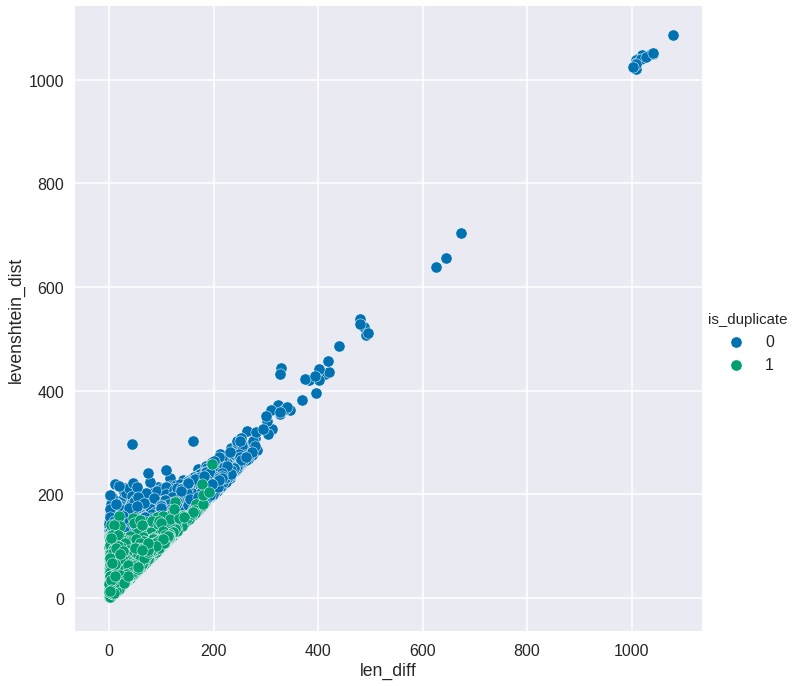

In [157]:
sns.pairplot(data=train_data_clean, hue='is_duplicate', 
             size=10, x_vars='len_diff', y_vars='levenshtein_dist')

In [18]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [160]:
gbt_clf = GradientBoostingClassifier()
rf_clf = RandomForestClassifier()

In [167]:
X_train = train_data_clean[['len_diff', 'levenshtein_dist']].values

In [168]:
rf_scores = cross_val_score(rf_clf, X=X_train, y=y_train, 
                            cv=10, n_jobs=-1, scoring='neg_log_loss')

In [169]:
gbt_scores = cross_val_score(gbt_clf, X=X_train, y=y_train, 
                            cv=10, n_jobs=-1, scoring='neg_log_loss')

In [170]:
score_df['random_forest'] = pd.Series(rf_scores)
score_df['gradient_boost'] = pd.Series(gbt_scores)
score_df.describe()

,naive_bayes,log_reg,lin_svm,random_forest,gradient_boost
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,-0.518208,-0.606932,0.200836,-0.703036,-0.588994
std,0.002792,0.000593,0.005101,0.008450,0.001316
min,-0.521154,-0.607860,0.194307,-0.718242,-0.591518
25%,-0.520711,-0.607194,0.197265,-0.707996,-0.589949
50%,-0.518813,-0.606919,0.199175,-0.701655,-0.588681
75%,-0.516140,-0.606506,0.203993,-0.698483,-0.587930
max,-0.513215,-0.606140,0.209435,-0.688724,-0.587389


In [171]:
from sklearn.model_selection import StratifiedShuffleSplit

In [172]:
splt = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=42)

In [175]:
train_idx, dev_idx = splt.split(X_train, y_train)

In [19]:
dups = train_data_clean[train_data_clean.is_duplicate == 1.0]
dups.shape

(149263, 11)

In [20]:
size_train = round(len(dups)*0.7)

In [21]:
df_X_train = train_data_clean[train_data_clean.is_duplicate == 0].sample(size_train)

In [22]:
df_Y_train = dups.sample(size_train)

In [23]:
test_idx = set(dups.id).difference(df_Y_train.id)

In [24]:
len(test_idx) + len(df_Y_train) == len(dups)

True

In [25]:
df_Y_test = dups.loc[test_idx]

In [26]:
non_dups = train_data_clean[(train_data_clean.is_duplicate == 0)]
remaining = set(non_dups.id).difference(df_X_train.id)

In [27]:
remaining_df = non_dups.loc[remaining]

In [28]:
df_X_test = remaining_df.sample(len(df_Y_test))

In [29]:
train_df = df_X_train.append(df_Y_train)
test_df = df_X_test.append(df_Y_test)

In [30]:
feature_vars_num = ['len_diff', 'levenshtein_dist', 'q1_length', 'q2_length']

In [52]:
X_train, Y_train = train_df[feature_vars_num].values, train_df.is_duplicate.values
X_test, Y_test = test_df[feature_vars_num].values, test_df.is_duplicate.values

In [32]:
rf_clf = RandomForestClassifier(n_estimators = 250, random_state=42, n_jobs=-1)

In [33]:
rf_clf = rf_clf.fit(X_train, Y_train)

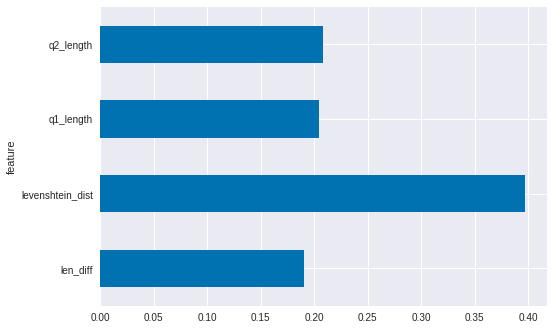

In [50]:
var_imp = pd.DataFrame({'feature': feature_vars_num,
                        'importance': rf_clf.feature_importances_})
var_imp.set_index('feature', inplace=True)
var_imp.importance.plot.barh(legend=False)

In [53]:
rf_preds = rf_clf.predict(X_test)

In [54]:
from sklearn.metrics import classification_report 

In [56]:
print(classification_report(y_pred=rf_preds, y_true=Y_test))

             precision    recall  f1-score   support

          0       0.67      0.62      0.65     44779
          1       0.65      0.69      0.67     44779

avg / total       0.66      0.66      0.66     89558



In [57]:
from sklearn.metrics import log_loss

In [58]:
log_loss(y_pred=rf_preds, y_true=Y_test)

11.845255841180887